# Machine learning algorithms on wholesale costumers data (ongoing)
## Predicting sales channel with SVM, Random Forest and XGBoost algorithms.

The problem is the following: given the annual spending on 6 different type of products of 440 wholesale customers, is it possible to predict the customers channel? In another notebook on this repo, *Principal Component Analyis on wholesale customers data*, I segmented these same costumers into three different groups and I found some differences between customer segment and channel, which is a positive indication that there is a pattern to be predicted.

The dataset I used can be found [here](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).
It is originated from a larger database referred on: 

*Abreu, N. (2011). Analise do perfil do cliente Recheio e desenvolvimento de um sistema promocional. Mestrado em Marketing, ISCTE-IUL, Lisbon*

Dataset variable description:

- FRESH: annual spending (m.u.) on fresh products (Continuous)
- MILK: annual spending (m.u.) on milk products (Continuous)
- GROCERY: annual spending (m.u.) on grocery products (Continuous)
- FROZEN: annual spending (m.u.) on frozen products (Continuous) 
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
- DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous) 
- **CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)** 
- REGION: customers Region - Lisbon, Oporto or Other (Nominal) 

In [25]:
import pandas as pd
%matplotlib inline

# Load the dataset
dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(dataset)

# List only continous variables (products), I'll deal with nominal vars later
products = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

In [101]:
df.shape

(440, 8)

In [107]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [240]:
df[products].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## t-SNE

In [20]:
from sklearn.manifold import TSNE

dtsne = TSNE(learning_rate=250).fit_transform(df[products])

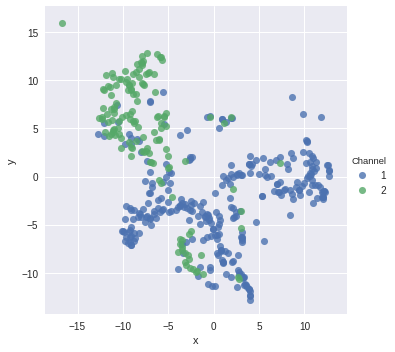

In [22]:
import seaborn as sns
tsnedf = pd.DataFrame({'x':dtsne[:,0],
                       'y':dtsne[:,1], 
                       'Channel':df['Channel'],
                       'Region':df['Region']})
sns.lmplot('x', 'y', 
           data=tsnedf, 
           fit_reg=False,
           hue='Channel',  
           scatter_kws={"marker": "D", 
                        "s": 50})

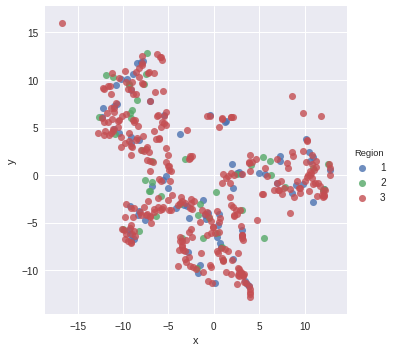

In [23]:
sns.lmplot('x', 'y', 
           data=tsnedf, 
           fit_reg=False,
           hue='Region',  
           scatter_kws={"marker": "D", 
                        "s": 50})

Judging by the tSNE plot, an unsupervised clustering method, the channel has two obvious clusters. The Region, on the other side, is scattered around the plot without any obvious clustering. The fact that the Channel is clustered is a good indication for the application of machine learning algorithms. I'll start with a simple algorithm, a Linear SVM.

## Support Vector Machine

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# do a 66-33 train/test data split. 

X_train, X_test, y_train, y_test = train_test_split(df[products], 
                                                    df['Channel'], 
                                                    test_size=0.33, 
                                                    random_state=42)

# try different params for GridSearch.

tuned_parameters = [{'kernel': ['linear'], 'C': [75, 100, 125]}]

# build a classifier with gridsearch
clf = GridSearchCV(SVC(C=1), 
                   tuned_parameters, 
                   cv=5,
                   scoring="accuracy",
                   n_jobs=8)

# Fit the classifier
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [75, 100, 125]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [102]:
clf.best_estimator_

SVC(C=75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [144]:
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))

Accuracy: 90.41%
Error: 9.59%


The linear SVM got around 90% of accuracy in a cross-validated gridsearch, with c=75 being the best predictor. 90% for the first attempt is good, but I'll try another methods to raise it a little bit (it still mislabels 1 customers channel out of 10).

## Random Forests

In [67]:
from sklearn.ensemble import RandomForestClassifier

# build the classifier
clf = RandomForestClassifier(criterion='entropy')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [194]:
# print accuracy and error
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))
accv = cross_val_score(cv=5, estimator=clf, X=X_train, y=y_train)
print("5-CV Accuracy: %.2f%%" % (np.mean(accv)*100))

Accuracy: 90.41%
Error: 9.59%
5-CV Accuracy: 90.49%


90.4% accuracy without any parameter tuning at all is good. It performs even better with 5-CV subsetting. Lets check if there are any near-optimal parameters we can search with Bayesian Optimization.

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from bayes_opt import BayesianOptimization


def rfccv(n_estimators, min_samples_split, max_features):
    
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=42
        ),
        X_train, y_train, 'f1', cv=5
    ).mean()
    return val


rfcBO = BayesianOptimization(
    rfccv,
    {'n_estimators': (10, 250),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999)}
)

rfcBO.maximize(n_iter=10)
print('-' * 53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

#### Optimized parameters:

- Max features:0.9881
- Min samples split: 2
- Number of estimators = 30

In [192]:
clfBO = RandomForestClassifier( max_features=0.9881, 
                               min_samples_split= 2, 
                               n_estimators= 30, random_state = 42)
clfBO.fit(X_train, y_train)

accuracy = accuracy_score(y_test, clfBO.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Error: %.2f%%" % (100-accuracy * 100.0))
accvbo = cross_val_score(cv=5, estimator=clfBO, X=X_train, y=y_train)
print("5-CV Accuracy: %.2f%%" % (np.mean(accvbo)*100))

Accuracy: 92.47%
Error: 7.53%
5-CV Accuracy: 92.54%


The Bayesian parameter optimization resulted in ~92.5% 5-cross-validation accuracy - a 2% increase over the baseline model. Lets check the feature importance.

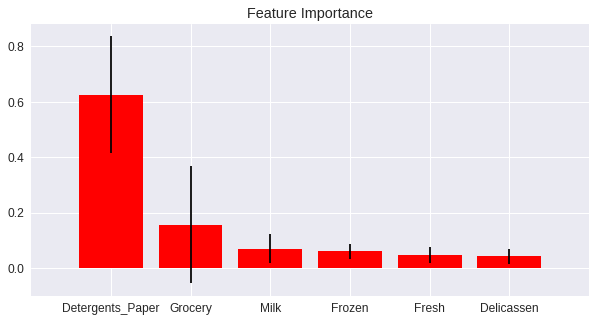

In [208]:
from scikitplot import plotters as skplt

# Plot feature importance
skplt.plot_feature_importances(clfBO, feature_names=products, figsize=(10,5))

According to the plot above, the most important features in this dataset to predict the customers channel are  Detergents/Paper and Grocery.

## XGBoost

Next I'll try to predict the Channel using XGBoost, a gradient boosting trees model which is very popular amongst Kaggle competitors, who boast its high speed and good accuracies without overfitting.

In [130]:
import xgboost

#build a classifier
xgb = xgboost.XGBClassifier(learning_rate =0.2, gamma=0,
                            objective='binary:logistic', seed=42)

#fit the classifier
xgb.fit(X_train, y_train)

accuracy = accuracy_score(y_test, xgb.predict(X_test))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.84%


~94% accuracy just out-of-the-box is way too impressive. It was also a very quick fit, opposed to the linear SVM which took around 15 minutes. I'll do a 5-fold cross validation to check how well the model performs in practice. This approach will create 5 different subsets of the dataset and average the scores to get a more robust estimate of model performance.

In [132]:
from sklearn.model_selection import KFold

# Try a 5-fold CV
accuracy = cross_val_score(xgb, X_test, y_test, cv=5)

print("Accuracy 5-fold CV: %.2f%% (±%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
print("Max accuracy 5-fold CV: %.2f%%" % (accuracy.max()*100))
print("Min accuracy 5-fold CV : %.2f%%" % (accuracy.min()*100))

Accuracy 5-fold CV: 89.79% (±3.65%)
Max accuracy 5-fold CV: 96.43%
Min accuracy 5-fold CV : 86.21%


The model performs well enough with 5-fold cross validation sets, but its far from the 94% against the test dataset. I'll try a Bayesian parameter optimization.

In [196]:
## Load Bayesian Optimization library
from bayes_opt import BayesianOptimization
import xgboost as xgb


## Define xgb classification model with 5-fold cross-validation
def xgb_BayesOpt(
                n_estimators,
                eta,
                max_depth, 
                gamma, 
                min_child_weight, 
                max_delta_step, 
                subsample,
                colsample_bytree
                ):
    params = {
                'gamma': gamma,
                'n_estimators': n_estimators,
                'booster': 'gbtree',
                'max_depth': max_depth.astype(int),
                'eta': eta,
                'objective': 'binary:logistic',
                'nthread' : 6,
                'silent': True,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree,
                'min_child_weight': min_child_weight,
                'max_delta_step': max_delta_step.astype(int),
                'seed': 42
             }
    
    cv_r=xgb.cv(
                params,
                dtrain,
                num_boost_round=10000,
                stratified=True,
                nfold=folds,
                verbose_eval=False,
                metrics=["error"],
                callbacks=[xgb.callback.early_stop(1000)]
                )

    return(-cv_r['test-error-mean'].values[-1])

## Place BayesOpt object with dict of arrays w/ possible values for each parameter.
xgb_BO = BayesianOptimization(xgb_BayesOpt, {'max_depth': (2,4),
                                             'n_estimators': (25,200),
                                             'eta': (0.075, 0.4),
                                             'gamma': (0, 0.1),
                                             'min_child_weight': (1, 2),
                                             'max_delta_step': (0, 1),
                                             'subsample': (0.5, 1),
                                             'colsample_bytree': (0.5, 1)})

## Define BayesOpt parameters and dataset.
dtrain = xgb.DMatrix(X_train, y_train-1)
random_state = 42
num_iter = 15
init_points = 5
folds = 5

## Start parameter tuning -> attempt to search parameters that minimize error mean.
xgb_BO.maximize(init_points=init_points, 
                n_iter=num_iter,
                acq='ucb', kappa=2)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |     gamma |   max_delta_step |   max_depth |   min_child_weight |   n_estimators |   subsample | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[2]	train-error:0.0799242+0.00552045	test-error:0.0782584+0.0332782

    1 | 00m00s |   -0.07826 |             0.8487 |    0.3482 |    0.0929 |           0.8368 |      2.7648 |             1.6132 |       154.4115 |      0.5987 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[27]	train-error:0.0433646+0.00730325	test-error:0.0815312+0.043289

    2 | 00m00s |   

/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.94099371e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |     gamma |   max_delta_step |   max_depth |   min_child_weight |   n_estimators |   subsample | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[41]	train-error:0.0357086+0.00687886	test-error:0.0815898+0.0361088

    6 | 00m34s |   -0.08159 |             0.6142 |    0.1502 |    0.0854 |           0.9064 |      3.9999 |             1.9769 |       197.3692 |      0.6361 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[20]	train-error:0.0459178+0.00563984	test-error:0.0748102+0.0348581



/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    7 | 00m18s |   -0.07481 |             0.7361 |    0.2510 |    0.0118 |           0.9846 |      2.1283 |             1.0446 |       101.9301 |      0.9161 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[65]	train-error:0.0416624+0.00865615	test-error:0.0782+0.0394744

    8 | 00m25s |   -0.07820 |             1.0000 |    0.0750 |    0.0000 |           1.0000 |      4.0000 |             1.0000 |        82.7110 |      0.5000 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[22]	train-error:0.0527156+0.00784944	test-error:0.0849796+0.0301922



/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.41795569e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


    9 | 00m28s |   -0.08498 |             0.5000 |    0.4000 |    0.0000 |           1.0000 |      2.0000 |             2.0000 |        31.1104 |      0.5000 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[17]	train-error:0.0297622+0.00761219	test-error:0.0917592+0.0347442

   10 | 00m22s |   -0.09176 |             0.6035 |    0.3645 |    0.0384 |           0.9826 |      3.8446 |             1.0354 |       127.8010 |      0.8663 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[74]	train-error:0.0578146+0.00949212	test-error:0.0815312+0.0360471

   11 | 00m28s |   -0.08153 |             1.0000 |    0.0750 |    0.1000 |           1.0000 |      2.0000 |             2.0000 |       200.0000 |      0.5000 | 
Multiple eval metrics have been

/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  5.59174471e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 00m37s |   -0.08165 |             0.6153 |    0.3540 |    0.0287 |           0.9936 |      2.1167 |             1.8933 |       175.6917 |      0.7134 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[35]	train-error:0.0663254+0.0095435	test-error:0.0883694+0.0290007

   15 | 00m38s |   -0.08837 |             0.5000 |    0.0750 |    0.0000 |           0.0000 |      2.0000 |             1.0000 |        96.0165 |      0.5000 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[37]	train-error:0.0442156+0.00832698	test-error:0.0815898+0.0376664



/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011019]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   16 | 00m37s |   -0.08159 |             0.9981 |    0.0815 |    0.0688 |           0.9907 |      3.9975 |             1.7609 |        25.1565 |      0.9021 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[7]	train-error:0.043361+0.0105302	test-error:0.0815898+0.0327724

   17 | 00m45s |   -0.08159 |             1.0000 |    0.4000 |    0.1000 |           1.0000 |      4.0000 |             1.9974 |       103.0399 |      1.0000 | 
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
Stopping. Best iteration:
[15]	train-error:0.0416588+0.00726611	test-error:0.0748102+0.0449383

   18 | 00m40s |   -0.07481 |             0.5270 |    0.1290 |    0.0765 |           0.9702 |      3.8440 |             1.0688 |       162.2580 |      0.9671 | 
Multiple eval metrics have been pa

In [197]:
#### Optimized parameters
xgb2 = xgboost.XGBClassifier(colsample_bytree=  1,
                             learning_rate = 0.4 ,
                             gamma = 0.1,
                             max_delta_step = 1,
                             max_depth = 4,
                             min_child_weight = 2,
                             n_estimators = 4,
                             subsample = 0.5 ,
                             objective='binary:logistic', 
                             seed=42)
xgb2.fit(X_train, y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.4, max_delta_step=1, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=4, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.5)

In [200]:
# Try a 10-fold CV eval
accuracy = cross_val_score(xgb2, X_train, y_train, cv=5)

print("Accuracy 5-fold CV: %.2f%% (±%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
print("Max accuracy 5-fold CV: %.2f%%" % (accuracy.max()*100))
print("Min accuracy 5-fold CV : %.2f%%" % (accuracy.min()*100))

Accuracy 5-fold CV: 90.82% (±2.29%)
Max accuracy 5-fold CV: 93.22%
Min accuracy 5-fold CV : 88.14%


This optimized model performs slightly better (+1%) than the baseline.


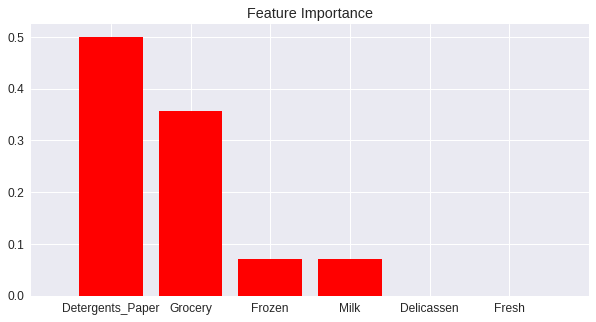

In [207]:
skplt.plot_feature_importances(xgb2, feature_names=products, figsize=(10,5))

The more a feature is used to make key decisions within decision trees, the higher its relative importance is. In this case, the Detergents/Paper and Gorcery features had the highest importance in predicting the channel while Delicatessen and Fresh had the lowest. his result seems concordant with the previous importance plot obtained with the RandomForest classifier. 

I'll plot the first decision tree for examples sake (as an ensemble method, this model has various predictor decision trees).

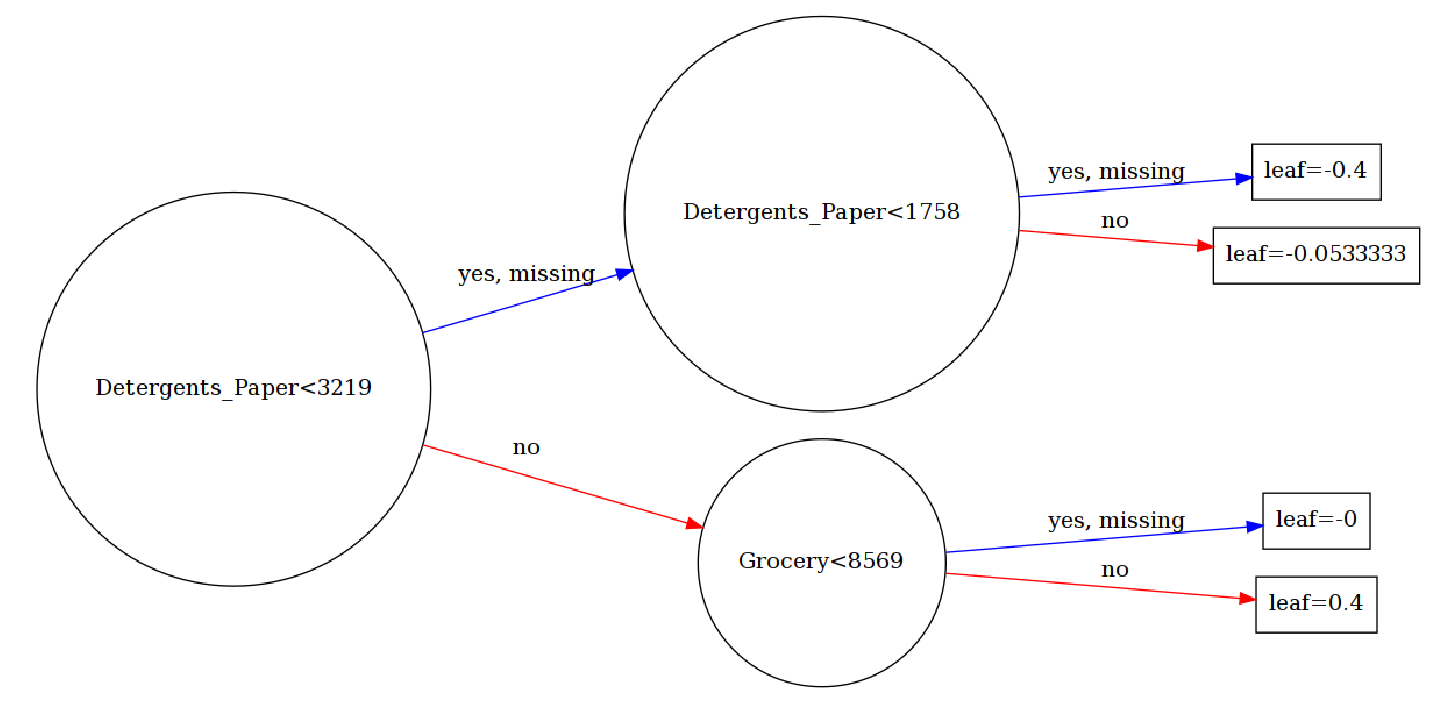

In [224]:
fig, ax = plt.subplots(figsize=(25,15))
xgboost.plot_tree(xgb2, rankdir='LR', num_trees= 0, ax=ax)

In [130]:
## This chunk is only relevant for Jupyter Notebook aesthetics.
from pylab import rcParams
import json
s = json.load( open("/home/hypathia/bmh_matplotlibrc.json") ) 
rcParams.update(s)

from IPython.core.display import HTML
def css_styling():
    styles = open("/home/hypathia/custom.css", "r").read() 
    return HTML(styles)
css_styling()